<a id = 'bus_stop'></a>

![purple-divider](https://user-images.githubusercontent.com/7065401/52071927-c1cd7100-2562-11e9-908a-dde91ba14e59.png)

<h1 align="center"> Multinomial Logit Model of Transport Choices in Khirdalan and Sumgait</h1>

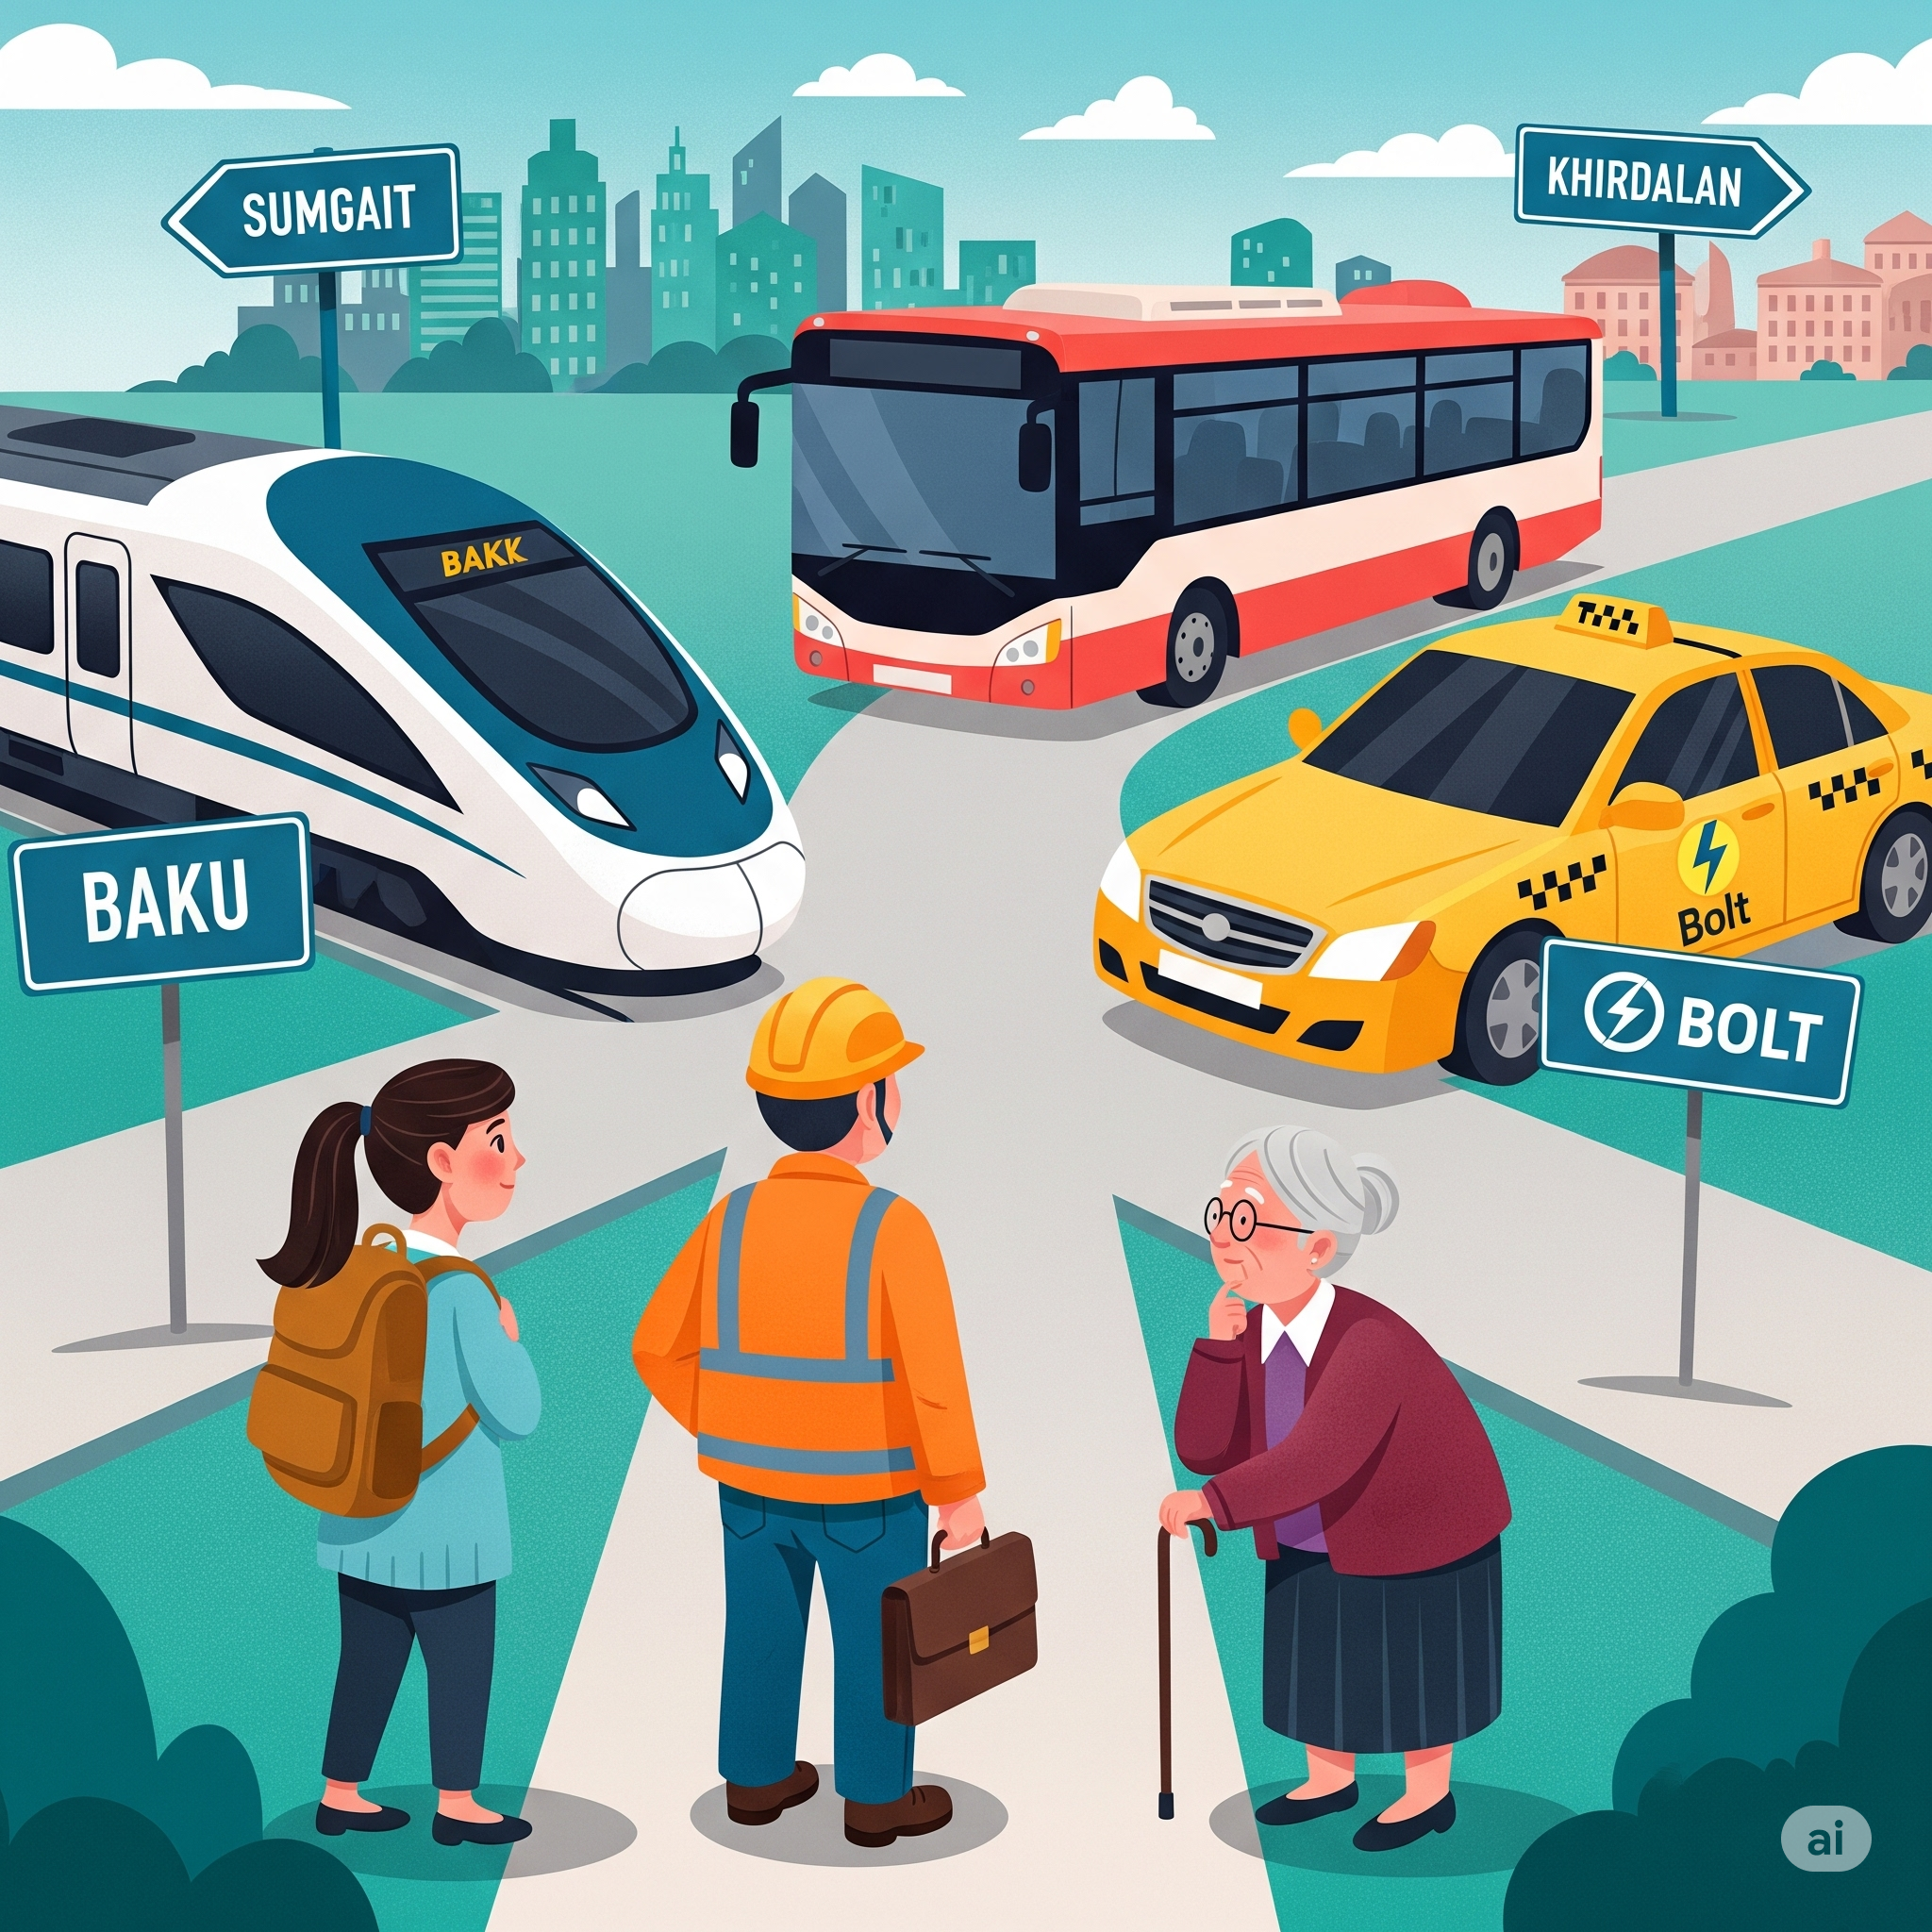

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import statsmodels.api as sm
from scipy import stats
from statsmodels.formula.api import logit
import pylogit as pl
from collections import OrderedDict

The dataset was obtained from a survey on transportation choices of 110 travelers in Khirdalan and Sumgait. These commuters use four modes of transportation: bus, fast train, taxi, and private car.


In [1113]:
df = pd.read_excel('survey_data.xlsx', names = ["timestamp", "location", "age", "gender", "employment_status", "monthly_income",
    "available_modes", "choice", "comfort_rating", "wait_time", "walk_time",
    "daily_cost", "crowdedness", "travel_areas", "trip_purpose", "peak_hours","suggestion","mainly_used_buses"
],header = 0)
df.head(3)

timestamp  location  age gender employment_status  \
0 2025-08-03 10:18:07.457  Xırdalan   26  Qadın             İşsiz   
1 2025-08-03 10:35:21.978  Sumqayıt   26  Qadın              İşçi   
2 2025-08-03 10:37:40.985  Xırdalan   29  Qadın              İşçi   

  monthly_income               available_modes        choice  comfort_rating  \
0    0 - 500 AZN  Avtobus, Taksi, Sürət qatarı       Avtobus               4   
1    0 - 500 AZN         Avtobus, Sürət qatarı  Sürət qatarı               5   
2    0 - 500 AZN         Avtobus, Sürət qatarı       Avtobus               2   

      wait_time    walk_time     daily_cost crowdedness  \
0   6–10 dəqiqə  6–10 dəqiqə  2.00–3.00 AZN    Çox dolu   
1  11–15 dəqiqə   0–5 dəqiqə  2.00–3.00 AZN        Orta   
2   6–10 dəqiqə  6–10 dəqiqə  2.00–3.00 AZN    Çox dolu   

                         travel_areas      trip_purpose  \
0  Nərimanov, Nəsimi, Xətai, Xırdalan  Ailə/şəxsi səbəb   
1          Nərimanov, Xətai, Sumqayıt                İş   
2            Yasamal, Xətai, Xırdalan                İş   

                                    peak_hours  \
0                 12:00 – 15:00, 18:00 – 21:00   
1                 09:00 – 12:00, 15:00 – 18:00   
2  06:00 – 09:00, 15:00 – 18:00, 18:00 – 21:00   

                           suggestion               mainly_used_buses  
0                    Xırdalan -28 May                   199, 508, 525  
1                    Sumqayıt- Nəsimi                     10, 5, 22,   
2  Xirdalan yasamal\nXirdalan koroglu  199 \n569\n525\n508\n18\n193\n

In [1115]:
df.shape

(110, 18)

##### Here are the chosen business questions that need to be answered:

* How sensitive are travelers to wait time, walk time,crowdness and travel cost?
* What's the impact of household trip purpose on traveler's choice?

Multinomial logit will be applied

## Data cleaning and preprocessing

There are some columns that will not be used in DCM. They were requested by users for analysis purposes, not for the model. These columns need to be dropped.

##### Dropping unecessary columns for model

In [1122]:
df = df.drop(columns = ['timestamp','daily_cost','comfort_rating',
                        'travel_areas','peak_hours','suggestion','mainly_used_buses'])

##### Checking nulls

In [1125]:
df.isnull().sum()

location             0
age                  0
gender               0
employment_status    0
monthly_income       0
available_modes      0
choice               0
wait_time            0
walk_time            0
crowdedness          0
trip_purpose         0
dtype: int64

There is no null value

##### Handling with column inconsistencies

In [1129]:
# Avtobus + Metro is also technically should considered as bus, since there is no subway in these regions 
df.loc[df['choice'] == 'Avtobus + Metro','choice'] = 'Avtobus'

##### Converting Data to Long format
Our data shows one row per person which is not applicable for DCM model. We should first transform data to wide format

In [1132]:
long_data = []
for index,row in df.iterrows():
    available_modes = row['available_modes'].split(', ')
    for mode in available_modes:
        new_row = {
            'respondent_id' : index,
            'location':row['location'],
            'age':row['age'],
            'gender':row['gender'],
            'employment_status' : row['employment_status'],
            'monthly_income':row['monthly_income'],
            'trip_purpose':row['trip_purpose'],
            'alternative':mode
        }
        new_row['chosen'] = 1 if mode == row['choice'] else 0
        if new_row['chosen'] == 1:
            new_row['crowdedness'] = row['crowdedness']
            new_row['walk_time'] = row['walk_time']
            new_row['wait_time'] = row['wait_time']
        else:
            if mode == 'Avtobus':
                new_row['crowdedness'] = 'Çox dolu'
                new_row['walk_time'] = '6–10 dəqiqə'
                new_row['wait_time'] = '6–10 dəqiqə'
            
            if mode =='Şəxsi avtomobil':
                new_row['crowdedness'] = 'Az'
                new_row['walk_time'] = '0–5 dəqiqə'
                new_row['wait_time'] = '0–5 dəqiqə'
                
            if mode == 'Sürət qatarı':
                new_row['crowdedness'] = 'Orta'
                new_row['walk_time'] = '11–15 dəqiqə'
                new_row['wait_time'] = '21 dəqiqə və ya daha çox'
                
            if mode == 'Taksi':
                new_row['crowdedness'] = 'Az'
                new_row['walk_time'] = '0–5 dəqiqə'
                new_row['wait_time'] = '6–10 dəqiqə'
            
        long_data.append(new_row)
long_df = pd.DataFrame(long_data)

In [1133]:
conditions = [(long_df['location'] == 'Xırdalan') & (long_df['alternative'] == 'Avtobus'),
             (long_df['location'] == 'Xırdalan') & (long_df['alternative'] == 'Taksi'),
              (long_df['location'] == 'Xırdalan') & (long_df['alternative'] == 'Sürət qatarı'),
              (long_df['location'] == 'Xırdalan') & (long_df['alternative'] == 'Şəxsi avtomobil'),
              
              (long_df['location'] == 'Sumqayıt') & (long_df['alternative'] == 'Avtobus'),
              (long_df['location'] == 'Sumqayıt') & (long_df['alternative'] == 'Taksi'),
              (long_df['location'] == 'Sumqayıt') & (long_df['alternative'] == 'Sürət qatarı'),
              (long_df['location'] == 'Sumqayıt') & (long_df['alternative'] == 'Şəxsi avtomobil')]


costs = [1,6.5,0.8,1.5,1.4,14,1.2,3.5]
long_df['cost'] = np.select(conditions,costs,default = np.nan)

In [1136]:
long_df.head(2)

respondent_id  location  age gender employment_status monthly_income  \
0              0  Xırdalan   26  Qadın             İşsiz    0 - 500 AZN   
1              0  Xırdalan   26  Qadın             İşsiz    0 - 500 AZN   

       trip_purpose alternative  chosen crowdedness    walk_time    wait_time  \
0  Ailə/şəxsi səbəb     Avtobus       1    Çox dolu  6–10 dəqiqə  6–10 dəqiqə   
1  Ailə/şəxsi səbəb       Taksi       0          Az   0–5 dəqiqə  6–10 dəqiqə   

   cost  
0   1.0  
1   6.5

Creating new alternative_id column for model

In [1139]:
alt_map = {'Avtobus':1, 'Taksi':2, 'Sürət qatarı':3, 'Şəxsi avtomobil':4}
long_df['alternative_id'] = long_df['alternative'].map(alt_map)

## Encoding

In [1141]:
mappings = {'crowdedness': {'Az':1, 'Orta':2, 'Çox dolu':3},
            
'monthly_income' : {
     '0 - 500 AZN': 0,
    '501 - 1000 AZN': 1,
    '1001 - 1500 AZN': 2,
    '1501 - 2000 AZN': 3,
    '2001 AZN və yuxarı': 4},

    'wait_time' : {
     '0–5 dəqiqə': 0,
    '6–10 dəqiqə': 1,
    '11–15 dəqiqə': 2,
    '16–20 dəqiqə': 3,
    '21 dəqiqə və ya daha çox': 4},

          'walk_time' : {
     '0–5 dəqiqə': 0,
    '6–10 dəqiqə': 1,
    '11–15 dəqiqə': 2,
    '16–20 dəqiqə': 3,
    '21 dəqiqə və ya daha çox': 4}

           }
for column, mapping in mappings.items():
    long_df[column] = long_df[column].map(mapping)

In [1143]:
long_df = pd.get_dummies(long_df, columns = ['gender','employment_status','trip_purpose'],drop_first = True)

In [1145]:
long_df = pd.get_dummies(long_df, columns = ['location'])
long_df['location_Sumqayıt'] =long_df['location_Sumqayıt'].astype('int32')

In [1147]:
long_df.head()

respondent_id  age  monthly_income   alternative  chosen  crowdedness  \
0              0   26               0       Avtobus       1            3   
1              0   26               0         Taksi       0            1   
2              0   26               0  Sürət qatarı       0            2   
3              1   26               0       Avtobus       0            3   
4              1   26               0  Sürət qatarı       1            2   

   walk_time  wait_time  cost  alternative_id  gender_Qadın  \
0          1          1   1.0               1          True   
1          0          1   6.5               2          True   
2          2          4   0.8               3          True   
3          1          1   1.4               1          True   
4          0          2   1.2               3          True   

   employment_status_İşsiz  employment_status_İşçi  trip_purpose_Alış-veriş  \
0                     True                   False                    False   
1                     True                   False                    False   
2                     True                   False                    False   
3                    False                    True                    False   
4                    False                    True                    False   

   trip_purpose_Həkim/zəruri xidmət  trip_purpose_Təhsil  trip_purpose_İş  \
0                             False                False            False   
1                             False                False            False   
2                             False                False            False   
3                             False                False             True   
4                             False                False             True   

   trip_purpose_Əyləncə/istirahət  location_Sumqayıt  location_Xırdalan  
0                           False                  0               True  
1                           False                  0               True  
2                           False                  0               True  
3                           False                  1              False  
4                           False                  1              False

i wanna see whether sumgait people prefer taxi more than other alternatives than khirdan people. 

If it's not statistically significant, you can't conclude that there's a difference in taxi preference between the two locations.

## FIRST MODEL WITH ONLY ALTERNATIVE RELATED VARIABLES

In [1150]:
df1 = long_df.copy()
variable= ['cost','wait_time','walk_time','crowdedness']

In [1152]:
basic_specification = OrderedDict()
basic_names = OrderedDict()

In [1154]:
basic_specification['intercept'] = [2,3,4]
basic_names['intercept'] = ['Taksi : Coefficient','Sürət qatarı : Coefficient',
                            'Şəxsi avtomobil : Coefficient']

In [1156]:
for col in variable:
    basic_specification[col] = [[1,2,3,4]]
    basic_names[col] = [col]

In [1158]:
basic_specification

OrderedDict([('intercept', [2, 3, 4]),
             ('cost', [[1, 2, 3, 4]]),
             ('wait_time', [[1, 2, 3, 4]]),
             ('walk_time', [[1, 2, 3, 4]]),
             ('crowdedness', [[1, 2, 3, 4]])])

In [1058]:
basic_names

OrderedDict([('intercept',
              ['Taksi : Coefficient',
               'Sürət qatarı : Coefficient',
               'Şəxsi avtomobil : Coefficient']),
             ('cost', ['cost']),
             ('wait_time', ['wait_time']),
             ('walk_time', ['walk_time']),
             ('crowdedness', ['crowdedness'])])

In [1160]:
model1 = pl.create_choice_model(data = df1 , 
                                alt_id_col = 'alternative_id',
                                obs_id_col='respondent_id',
                                choice_col= 'chosen',
                                specification=basic_specification,
                                model_type='MNL',
                                names = basic_names)

In [1162]:
model1.fit_mle(np.zeros(7))
model1.get_statsmodels_summary()

Log-likelihood at zero: -53.6215
Initial Log-likelihood: -53.6215
Estimation Time for Point Estimation: 0.04 seconds.
Final log-likelihood: -25.5181


C:\Users\User\anaconda3\envs\dcm_env\lib\site-packages\pylogit\estimation.py:678: RuntimeWarning: Method BFGS does not use Hessian information (hess).
  results = minimize(estimator.calc_neg_log_likelihood_and_neg_gradient,


<class 'statsmodels.iolib.summary.Summary'>
"""
                     Multinomial Logit Model Regression Results                    
===================================================================================
Dep. Variable:                      chosen   No. Observations:                  110
Model:             Multinomial Logit Model   Df Residuals:                      103
Method:                                MLE   Df Model:                            7
Date:                     Fri, 22 Aug 2025   Pseudo R-squ.:                   0.524
Time:                             08:53:43   Pseudo R-bar-squ.:               0.394
AIC:                                65.036   Log-Likelihood:                -25.518
BIC:                                83.940   LL-Null:                       -53.621
=================================================================================================
                                    coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------------------
Taksi : Coefficient               0.2841      1.268      0.224      0.823      -2.201       2.769
Sürət qatarı : Coefficient        1.7651      0.669      2.640      0.008       0.455       3.076
Şəxsi avtomobil : Coefficient     0.0028      0.821      0.003      0.997      -1.607       1.612
cost                              0.1300      0.125      1.037      0.300      -0.116       0.376
wait_time                        -0.6154      0.247     -2.495      0.013      -1.099      -0.132
walk_time                        -0.3637      0.305     -1.194      0.232      -0.961       0.233
crowdedness                       2.0227      0.493      4.105      0.000       1.057       2.989
=================================================================================================
"""

R squared is 52% so model explains significant portion of people's choice.
* **Fast train:** coef = 1.7651 and it is statistically significant, so it means there is a strong preference for the fast train over the bus
* **Taxi and private car:** their coefficients are very low. It shows that they are not very different from bus for travelers. But both result are statistically not significant. Most probably due to small data size.
* **Cost:** It unexpectedly may seem that coefficient  is positive, as everyone would assume higher cost discourages use. But after considering real world behavior, people must use expensive options in order to commute. But P value is more than 0.05 here too. So we can't be sure this relationship is not due to random chance.
* **wait_time:** Statistically significant. The negative coefficient is logical. It shows that as wait time increases, the utility of all alternatives (relative to the bus) decreases.
* **walk_time:** Not statistically significant. This suggests that walk time isn't a key factor in this model, possibly because people are willing to walk to reach a mode that gets them to work. 
* **crowdedness:** The positive coefficient is very high and strongly significant. Typically, people prefer less crowded transport. However, this finding strongly supports real-world context where people have no choice but to use crowded options like the fast train to get to work. Therefore, they are not sensitive to crowdedness, or the model might capture that they associate crowdedness with more popular and efficient modes like the fast train.

In [1164]:
df1['choice_probability'] = model1.predict(df1)
df1['predicted_choice'] = df1.groupby('respondent_id')['choice_probability'].transform(
    lambda x: (x == x.max()).astype(int)
)

In [1105]:
def share_calculate(data, choice_col):
    share = data.groupby("alternative")[choice_col].sum()
    share = share / data["respondent_id"].nunique()
    
    return share.round(2) * 100

In [1109]:
share_calculate(df1, 'predicted_choice')

alternative
Avtobus            61.0
Sürət qatarı       18.0
Taksi               9.0
Şəxsi avtomobil    12.0
Name: predicted_choice, dtype: float64

Seems like taxi is the least preferrable choice here

Let's evaluate model's predictive performance by sckit learn classification report

In [1168]:
from sklearn.metrics import classification_report
print(classification_report(df1['chosen'],df1['predicted_choice']))

              precision    recall  f1-score   support

           0       0.88      0.85      0.86        92
           1       0.87      0.90      0.88       107

    accuracy                           0.87       199
   macro avg       0.87      0.87      0.87       199
weighted avg       0.87      0.87      0.87       199



Accuracy is 0.87 and other metrics are also high, means model is performing well in predictions

## SECOND MODEL WITH DEMOGRAPHIC VARIABLES

In [988]:
df2 = long_df.copy()

In [990]:
basic_specification['trip_purpose_İş'] = [2,3,4]
basic_names['trip_purpose_İş'] = ['Taksi : trip_purpose_work','Sürət qatarı : trip_purpose_work',
                                  'Şəxsi avtomobil : trip_purpose_work']

In [992]:
model2 = pl.create_choice_model(data = df2 , 
                                alt_id_col = 'alternative_id',
                                obs_id_col='respondent_id',
                                choice_col= 'chosen',
                                specification=basic_specification,
                                model_type='MNL',
                                names = basic_names)

In [994]:
model2.fit_mle(np.zeros(10))
model2.get_statsmodels_summary()

Log-likelihood at zero: -53.6215
Initial Log-likelihood: -53.6215
Estimation Time for Point Estimation: 0.05 seconds.
Final log-likelihood: -26.4098


C:\Users\User\anaconda3\envs\dcm_env\lib\site-packages\pylogit\estimation.py:678: RuntimeWarning: Method BFGS does not use Hessian information (hess).
  results = minimize(estimator.calc_neg_log_likelihood_and_neg_gradient,


<class 'statsmodels.iolib.summary.Summary'>
"""
                     Multinomial Logit Model Regression Results                    
===================================================================================
Dep. Variable:                      chosen   No. Observations:                  110
Model:             Multinomial Logit Model   Df Residuals:                      100
Method:                                MLE   Df Model:                           10
Date:                     Fri, 22 Aug 2025   Pseudo R-squ.:                   0.507
Time:                             07:40:51   Pseudo R-bar-squ.:               0.321
AIC:                                72.820   Log-Likelihood:                -26.410
BIC:                                99.824   LL-Null:                       -53.621
=======================================================================================================
                                          coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------------------------
Taksi : Coefficient                     0.4280      1.607      0.266      0.790      -2.722       3.578
Sürət qatarı : Coefficient              1.1507      1.136      1.012      0.311      -1.077       3.378
Şəxsi avtomobil : Coefficient           0.9425      1.128      0.835      0.404      -1.269       3.154
cost                                    0.0714      0.129      0.552      0.581      -0.182       0.325
wait_time                              -0.6576      0.265     -2.482      0.013      -1.177      -0.138
walk_time                              -0.3613      0.326     -1.107      0.268      -1.001       0.278
crowdedness                             2.1089      0.557      3.784      0.000       1.017       3.201
Taksi : trip_purpose_work               0.3249      1.034      0.314      0.753      -1.702       2.352
Sürət qatarı : trip_purpose_work        0.6103      1.175      0.519      0.604      -1.693       2.914
Şəxsi avtomobil : trip_purpose_work    -2.2981      1.659     -1.385      0.166      -5.550       0.953
=======================================================================================================
"""

* I added trip purpose (work ) as an interaction term to model, to check how traveler choice is affected by the purpose of the trip. The negative coefficient suggests that for work trips, a personal car is less desirable than the bus. This is likely due to the real world factors such as difficulty of finding affordable and close parking, as well as heavy traffic during peak commuting hours. Given that buses have dedicated bus lanes and fast train offers a faster and more predictable journey, many people prefer these public transport options over using a private car for commutes. However, the result is not statistically significant so we cannot be confident that this effect is not due to random chance.
  
* R squared is 50%, which is lower than in the previous model and the BIC is also higher. So it suggests that first model was performing better but lastly we will check classification report too.

In [996]:
df2['choice_probability'] =model2.predict(df2)
df2['predicted_choice'] = df2.groupby('respondent_id')['choice_probability'].transform(
    lambda x: (x == x.max()).astype(int)
)

In [998]:
from sklearn.metrics import classification_report
print(classification_report(df2['chosen'],df2['predicted_choice']))

              precision    recall  f1-score   support

           0       0.85      0.83      0.84        92
           1       0.85      0.88      0.87       107

    accuracy                           0.85       199
   macro avg       0.85      0.85      0.85       199
weighted avg       0.85      0.85      0.85       199



Accuracy is lower (85%) than previous model so we can confidently say that first model performed better without the inclusion of interaction term.

## SUMMARY (MAIN INSIGHTS)

* There is a strong preference for the fast train over the bus
* As wait time increases, the utility of all alternatives (relative to the bus) decreases.
* The positive and significant coefficient suggests that, contrary to typical expectations, travelers are not sensitive to crowdedness. This may reflect real-world behavior, where crowded options like the fast train are viewed as necessary or even as indicators of popularity and efficiency
* The negative coefficient indicates that personal cars are less preferred than buses for work trips, likely due to traffic and parking challenges. While public transport options like buses with dedicated lanes and fast trains are faster. But the effect is not statistically significant and may be due to chance.